##Executive Summary

In this project, we built a stochastic simulation to study a system that models how large language models (LLMs) process user queries. LLMs handle queries in two stages: a heavy prefill phase, where the system reads the entire input prompt and prepares to generate the first token, and a lighter decode phase, where the system generates each output token sequentially. Each query arrived randomly over time, had a predetermined prompt length, and a fixed or random output budget.

Our simulation modeled these dynamics on a single server (representing a GPU) that executed jobs in batches. Prefill tasks were compute-intensive and could saturate the server, while decode tasks were smaller and could be batched across multiple queries. We implemented two scheduling strategies: one that prioritized completing ongoing jobs before admitting new queries, and one that prioritized admitting new queries whenever possible, even if this delayed ongoing work. Random arrivals, random service times, and batching were all explicitly modeled, reflecting the stochastic nature of the system.

We validated our simulation against an M/M/1 queue in a simple case with no batching and exponential service times. In this limit, the simulator closely matched analytical predictions for mean latency and throughput, confirming that our implementation behaved correctly.

Through our experiments, we explored workload sensitivity by varying query arrival rates and prompt length distributions. We observed that the scheduler prioritizing new queries achieved higher throughput, especially across different prompt length configurations, but this came at the cost of large tail latency. The scheduler prioritizing completion of ongoing queries maintained more consistent latency to the first token but suffered lower throughput, particularly as the system approached high load. Prompt length had a larger effect on performance than mean arrival rate alone, emphasizing the importance of accounting for varying workloads in scheduling decisions.

Overall, the simulation demonstrated how stochastic modeling can reveal trade-offs in complex service systems like LLM query serving. Small local scheduling decisions produced large effects on global performance, affecting throughput, average latency, and tail latency. The project highlights the value of simulation for testing alternative scheduling policies, understanding system behavior under variable workloads, and quantifying the impact of design choices in realistic, stochastic environments.



# Modeling Approach
**Overview of LLM Serving**

When a user sends a query to a system like ChatGPT, the response does not appear all at once. Instead, users usually see a small pause, then text appears word by word. This happens because of how these systems process requests. Every query goes through two phases:  

**Prefill:** The system processes the user's entire prompt to build an internal state (the Key-Value cache). This phase is compute-heavy and must complete before any output is generated.  

**Decode:** The system generates response tokens sequentially, one at a time. Each token requires a separate computation step, but individual steps are relatively fast.  

This two-phase structure creates the core scheduling challenge: the GPU may have spare capacity during decode steps that could be used to start processing new queries. Our simulation models this dynamic to compare different scheduling approaches.  

**System Model**

In our simulation, we model a single GPU server handling user queries. The system maintains two queues: a prefill queue for queries waiting to have their prompts processed, and a decode queue for queries actively generating output tokens. The GPU processes work in batches, where each batch can contain prefill tokens and/or decode tokens from multiple queries.  Our implementation uses a discrete-event simulation approach.

The main event types are:   

**Arrival events:** New queries enter the prefill queue   

**Prefill completion:** A query's prompt processing finishes, moving it to decode   

**Decode completion:** A query generates one output token (or finishes entirely)  The run_decode_first() and run_prefill_first() functions in our code implement two different scheduling policies using this event-driven structure.  

**Key Assumptions**

**Arrival Process.** We assume queries arrive randomly according to a Poisson process with rate    λ = 1.0 queries per second. This is implemented using exponential inter-arrival times. The Poisson assumption is common for web services and allows us to validate our results.  

**Query Characteristics.** Every query has the same prompt length (32 tokens) and output budget (8 tokens). Real workloads have high variability, but this simplification lets us isolate the effect of scheduling policy from workload effects.   

**Service Time Model.** We adopt the piecewise-linear model from Li et al. (2024), who measured actual GPU processing times:  

$$S(b)=c+a⋅max⁡(0,b-b_0)$$

where b is the number of tokens in a batch, c is a fixed setup cost, a is the marginal cost per token beyond threshold b₀. The generate_service_time() function implements this with exponential randomness. The exponential distributions preserve the expected piecewise-linear structure while adding realistic variance.  

**Batching Constraints.** A batch can contain multiple prefill tokens from the same query, but at most one decode token per query (since token t+1 depends on token t). Decode tokens from different queries can share a batch.  

**Parameters**

We based our parameters on Li et al. (2024), who measured Llama-3-70B on A100 GPUs:   

Setup cost (c): 30 ms — fixed overhead per batch regardless of size  

Token cost (a): 0.25 ms/token — marginal cost for tokens beyond threshold   
Threshold (b₀): 16 tokens — batch size where linear scaling kicks in

Max batch (K): 64 tokens — limit on batch size   
Arrival rate (λ): 1.0 queries/second   
Prompt length (L): 32 tokens   
Output budget (B): 8 tokens  

With these parameters, a single query takes approximately 34 milliseconds for prefill (32 tokens exceeds the threshold of 16, so S(32) = 30 + 0.25 × 16 = 34 ms) plus 8 × 30 ms = 240 ms for decode steps (each decode is 1 token, below threshold), totaling ~274 ms. At λ = 1.0 queries/sec, the system runs at moderate utilization, enough to see the queueing effects without becoming unstable. The warmup time for our simulation allows transient startup effects to settle before collecting statistics.  

**Performance Metrics**

We track metrics corresponding to user experience and system efficiency:   

**Time to First Token (TTFT):** Elapsed time from query arrival to first output token. This measures how long users wait before seeing any response.   

**Time Between Tokens (TBT):** Time between consecutive output tokens. This determines the perceived "streaming speed" of responses. Consistent, low TBT feels like smooth typing; high or variable TBT feels choppy.   

**Throughput:** Completed queries per second, measuring system capacity.  

For latency metrics, we report both mean and P95 (95th percentile) to capture typical and worst-case experiences.  

**Scheduling Policies Implemented**

Decode-First processes queries one at a time: complete all prefill tokens, then all decode tokens, before starting the next query. This is simple but forgoes batching opportunities and could be potentially wasteful.  

Prefill-First prioritizes new prefills while batching decode tokens from multiple active queries. When the GPU becomes free, start_batch() first adds pending prefills (up to batch capacity), then fills remaining space with decode tokens from different queries. This increases throughput but adds scheduling complexity.  

# Model Details

This section provides the technical specification of our simulation model. High-level assumptions and parameter values are described in the preceding sections; here we detail the implementation.

**Service Time Model**

We model batch processing time as:

$$S(b) = c + a \cdot \max(0, b - b_0)$$

where $b$ is the total token count in the batch. We implement this by sampling:
- **Setup time**: $C \sim \text{Exp}(c)$ — fixed overhead per batch
- **Per-token time**: $\sum_{i=1}^{\max(0, b-b_0)} A_i$ where $A_i \sim \text{Exp}(a)$ — marginal cost for tokens beyond threshold

For batches with $b \leq b_0$, service time reduces to $\text{Exp}(c)$ (setup only). Consequently, single-token decode batches ($b = 1$) incur the full setup overhead—not because decode has zero marginal cost, but because $1 \leq b_0$. Batching improves GPU utilization by amortizing the setup cost $c$ across multiple tokens. The GPU is busy whenever a batch is executing and idle otherwise.

**Batching Constraints**

- **Capacity**: At most $K$ tokens per batch
- **Autoregressive decoding**: One decode token per query per batch (token $t+1$ depends on token $t$)
- **Atomic prefills**: A query's entire prefill ($L$ tokens) must fit in a single batch; partial prefills are not permitted

**Benchmark Scheduling Policies**

We evaluate two scheduling policies that represent opposite ends of a design spectrum:

| Policy | Strategy | Batching | Represents |
|--------|----------|----------|------------|
| **Decode-First** | Complete each query before starting next | None | Simple baseline (FCFS) |
| **Prefill-First** | Prioritize new queries; batch decode tokens | Yes | Throughput-optimized |

These benchmarks allow us to isolate the impact of batching and scheduling priority on latency and throughput metrics.

**Decode-First / FCFS (Request-Level)**

This policy serves as our **baseline**. It processes each query to completion before admitting the next, similar to a traditional FCFS queue. No batching occurs across queries.

```
while simulation running:
    if GPU idle and queue not empty:
        query ← queue.pop()
        GPU.process(L tokens)            # Prefill: S(L)
        query.first_token_time ← now
        for i = 1 to B:
            GPU.process(1 token)         # Decode: S(1) each
        record_completion(query)
```

Each decode incurs a separate setup cost, making this policy inefficient when $c$ is large relative to per-token cost. However, it provides predictable per-query latency and simple implementation.

**Prefill-First (Iteration-Level Batching)**

This policy represents a **throughput-optimized** approach. It prioritizes admitting new queries (prefills) and batches decode tokens from multiple active queries to amortize setup costs.

```
while simulation running:
    if GPU idle and (prefill_queue or decode_queue not empty):
        batch ← [], tokens ← 0
        
        # Prefills first (must fit entirely)
        while prefill_queue not empty and tokens + L ≤ K:
            query ← prefill_queue.pop()
            batch.add(query, "prefill", L)
            tokens ← tokens + L
        
        # Fill remaining capacity with decodes
        for query in decode_queue:
            if tokens ≥ K: break
            if query not in batch:
                batch.add(query, "decode", 1)
                tokens ← tokens + 1
        
        GPU.process(batch)               # Single S(tokens) for entire batch
        
        # Update states: prefills → decode_queue, finished queries → record
```

Batching amortizes the setup cost $c$ across multiple tokens, improving throughput at the cost of potentially delaying individual decode tokens behind new prefills.

**Iteration Timeline Example**

We illustrate the difference between policies using a simplified scenario with $B = 2$ decode tokens per query (our full simulation uses $B = 8$). Two queries arrive: Q1 at $t = 0$, Q2 at $t = 5$ ms. Other parameters: $L = 32$, $c = 30$ ms, $b_0 = 16$.

**Decode-First:**

| Time (ms) | Event | Batch Size | Service Time |
|-----------|-------|------------|--------------|
| 0 | Prefill Q1 | 32 tokens | S(32) ≈ 34 ms |
| 34 | Decode Q1 (token 1) | 1 token | S(1) ≈ 30 ms |
| 64 | Decode Q1 (token 2) | 1 token | S(1) ≈ 30 ms |
| 94 | Prefill Q2 | 32 tokens | S(32) ≈ 34 ms |
| 128 | Decode Q2 (token 1) | 1 token | S(1) ≈ 30 ms |
| 158 | Decode Q2 (token 2) | 1 token | S(1) ≈ 30 ms |
| **188** | **Both complete** | | |

**Prefill-First:**

| Time (ms) | Event | Batch Size | Service Time |
|-----------|-------|------------|--------------|
| 0 | Prefill Q1 | 32 tokens | S(32) ≈ 34 ms |
| 34 | Prefill Q2 + Decode Q1 | 33 tokens | S(33) ≈ 34.25 ms |
| 68 | Decode Q1 + Q2 | 2 tokens | S(2) ≈ 30 ms |
| 98 | Decode Q2 (final) | 1 token | S(1) ≈ 30 ms |
| **128** | **Both complete** | | |

Prefill-First completes both queries in 128 ms versus 188 ms for Decode-First—a 32% reduction. The improvement comes from (1) starting Q2's prefill earlier and (2) batching decode tokens to share setup overhead.

**Validation**

We validated our simulation by reducing it to an M/M/1 queue, for which analytical results are known. Setting $c = 0$, $b_0 = 0$, $L = 1$, and $B = 0$ yields i.i.d. $\text{Exp}(a)$ service times with no batching effects. In this configuration, TTFT equals the sojourn time (time in system).

Our simulated mean sojourn times match the theoretical prediction W = a/(1-ρ), confirming correct queue dynamics at low utilization. We exclude a warmup period of 10 seconds to remove initialization bias. Full validation results, including run lengths and replication counts, are provided in the Technical Appendix.


# Analysis

We studied the workload sensitivity of our LLM-serving system using our simulutaor above.  We varied arrival rates, prompt lengths, and output budgets while holding all other system parameters fixed. For each configuration, we measure mean and P95 latency metrics—Time To First Token (TTFT) and Time Between Tokens (TBT)—as well as overall throughput.

### Arrival Rate Sensitivity

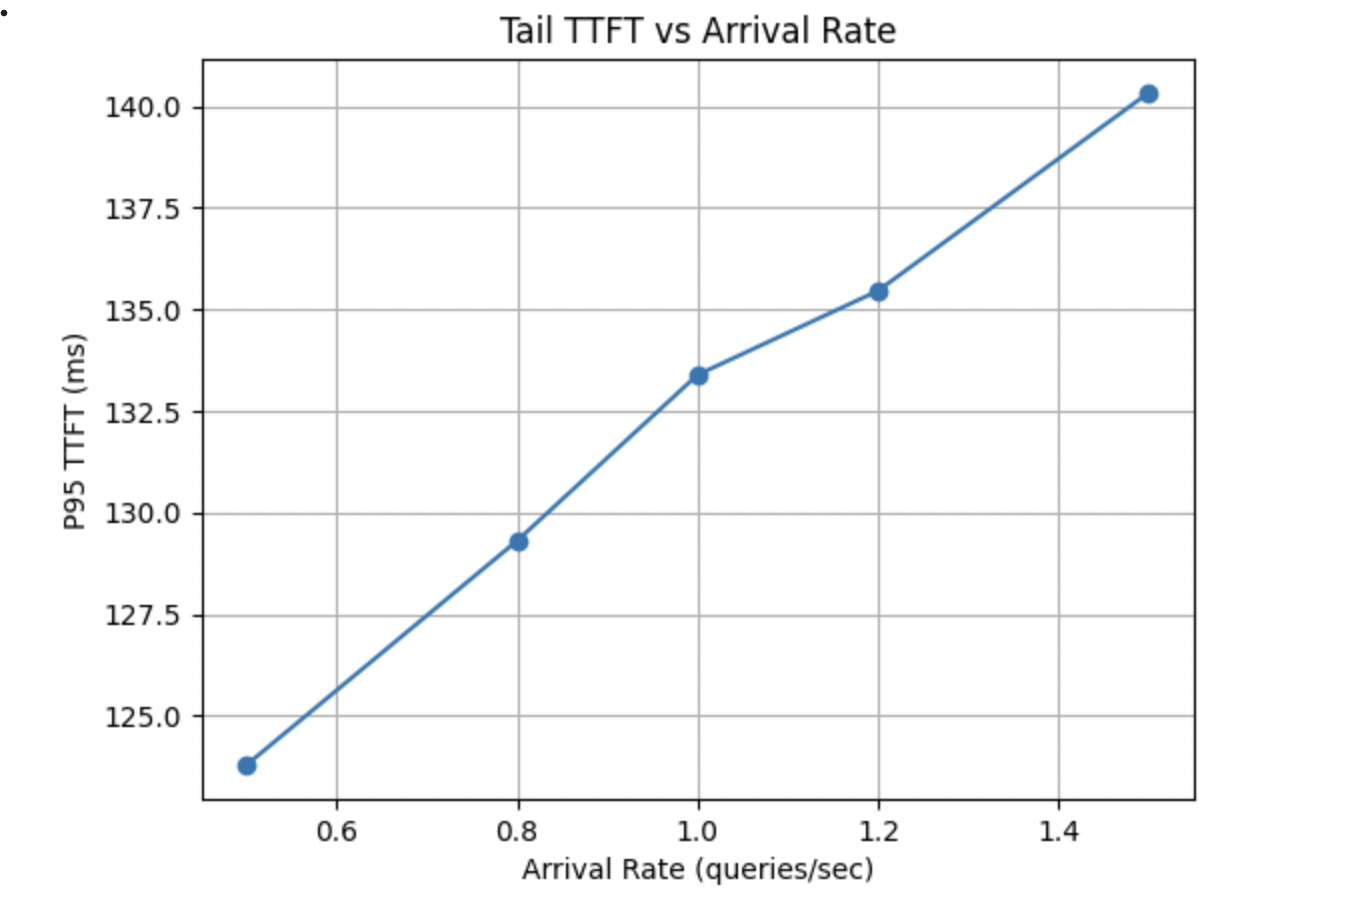

We first analyzed the sensitivity of the system to changes in query arrival rate. We held PROMPT_LENGTH constant at 32 tokens and we held OUTPUT_BUDGET constant at 8 tokens. This experiment is designed to identify capacity limits and phase transitions in system behavior.

We plotted the mean and P95 TTFT as a function of arrival rate. At low arrival rates (λ = 0.5 queries/sec), P95 TTFT is relatively small, reflecting a lightly loaded system where most queries experience little to no waiting before prefill execution. As arrival rate increases to 0.8 queries/sec, tail TTFT increases linearly, suggesting that GPU utilization is increasing and that some queries begin to experience queueing delays during the prefill phase.

Between λ = 1.0 and λ = 1.2 queries/sec, P95 TTFT increases linearly at a smaller rate, indicating that the system is approaching saturation, where incoming queries accumulate faster than they can be served. Queueing delay dominates service time, leading to significant growth in tail latency.

Overall, the near-linear growth confirms that batching effectively manages queue buildup under moderate load and maintains consistent tail latency performance. The small incremental increase (~16ms over 1.0 q/s range) primarily reflects batch formation delays and minor queueing effects rather than capacity constraints. This suggests the current configuration can safely handle arrival rates up to 2.0+ q/s before approaching saturation.


### Prompt Length Sensitivity

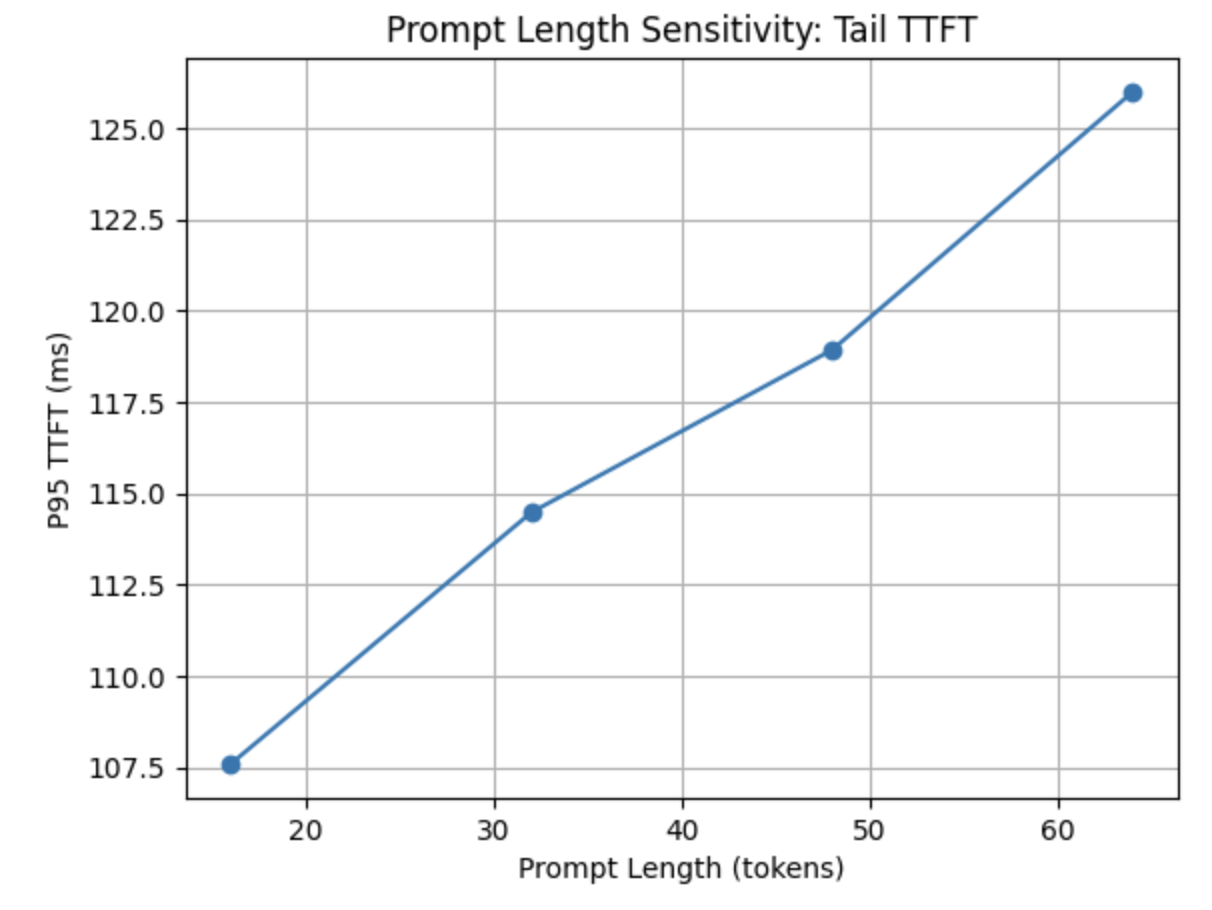

Next, we analyzed the effect of prompt length on system performance, which determines the amount of prefill computation required before the first output token can be generated. We held ARRIVAL_RATE constant at 1 query/sec and held OUTPUT_BUDGET constant at 8 tokens.

We plotted the effect of prompt length on tail latency (P95 TTFT), with arrival rate and output budget held fixed. For short prompts (15 tokens), P95 TTFT is relatively low, indicating that prefill computation completes quickly and queries experience minimal queueing delay. As prompt length increases , tail TTFT increases linearly, consistent with the increased amount of prefill work required before the first token can be generated. At 32 tokens P95 TTFT increases linearly at a smaller rate.


Overall, the growth rate confirms that our Prefill-First scheduler effectively handles variable prompt lengths through batching, preventing severe head-of-line blocking. All measured P95 TTFT values remain well below 150ms, indicating acceptable latency even for longer prompts under current configuration. For production workloads with prompts exceeding 100+ tokens, we recommend implementing chunked prefill to further improve fairness and reduce tail latency for short queries that would otherwise wait behind long prefills.

### Output Budget Sensitivity

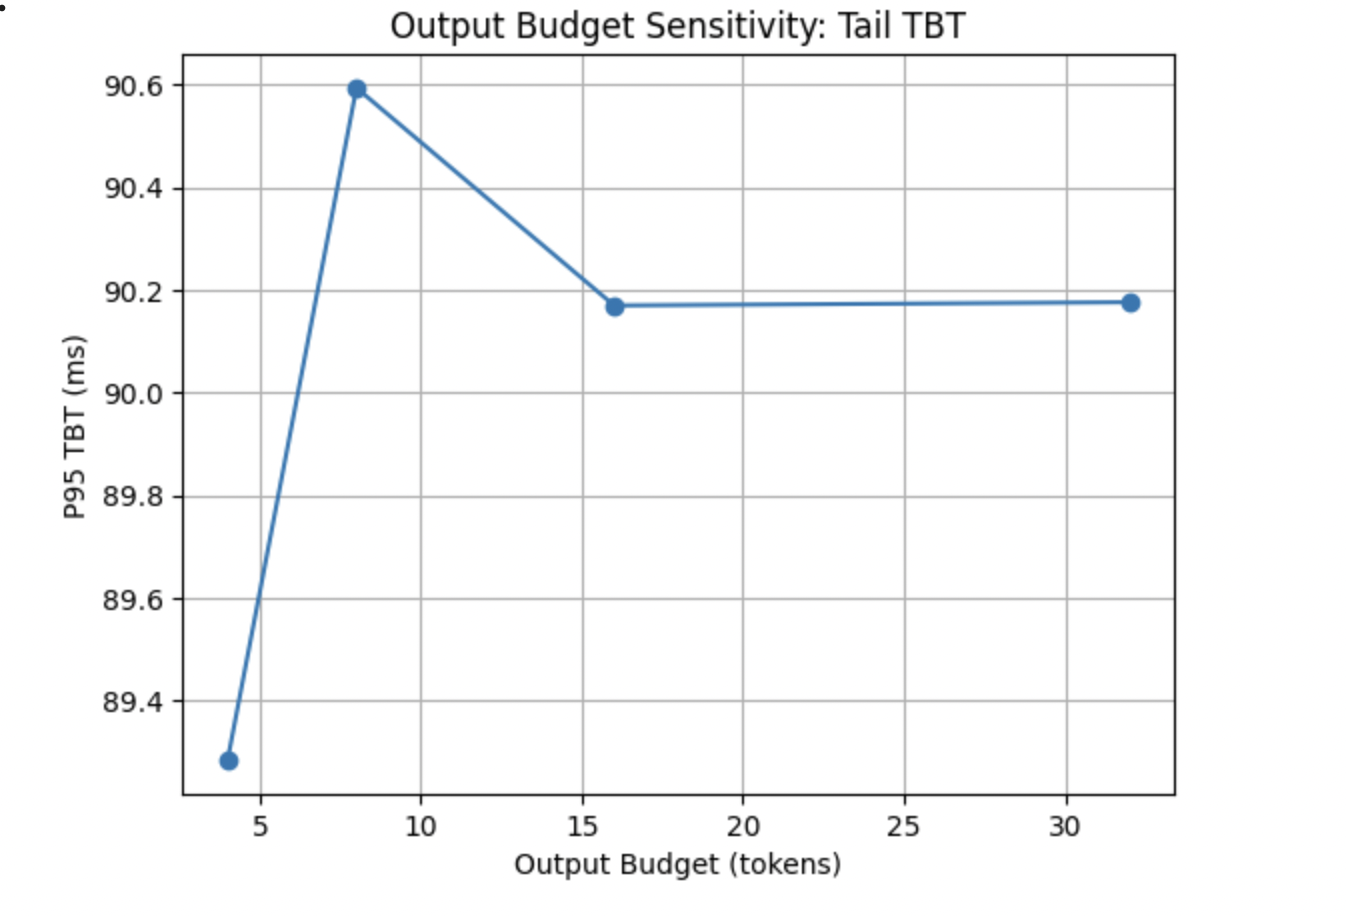

Finally, we analyze the impact of output budget (i.e., the number of tokens generated during decoding). We held ARRIVAL_RATE constant at 1 query/sec and held PROMPT_LENGTH constant at 32 tokens, while OUTPUT_BUDGET is varied from 4 to 32 tokens.

Our plot shows how the output budget affects tail token-to-token latency (P95 TBT), with arrival rate and prompt length held constant. Increasing the output budget leads to an increase in tail TBT.

For small output budgets (4 tokens), P95 TBT is lowest. Decode phases are short, allowing the scheduler to interleave decode tokens efficiently across queries with minimal queueing. GPU contention during decode is limited, resulting in relatively stable token emission intervals.

Tail TBT increases linearly until we hit 8 output budget tokens, and then it descreases linearly until we hit 16 output budget tokens. For output budget >=16, tail TBT plateaus. This suggests that increasing output length beyond this threshold has negligible impact on per-token latency—a critical finding for capacity planning. All measured P95 TBT values remain below 91ms, ensuring smooth token streaming regardless of response length.


Overall, these results demonstrate that output budget is a key driver of token-level latency. While longer generations improve response completeness, they directly degrade tail TBT by increasing decode queue occupancy. For production deployment, these results indicate that output budget has minimal impact on system capacity. Unlike prompt length or arrival rate, operators can treat variable output lengths as nearly equivalent for capacity planning purposes, significantly simplifying resource provisioning decisions.

### Confidence Bounds

To quantify uncertainty in our estimates, we ran **5 independent replications** using seeds 42, 123, 456, 789, and 1011. For each replication, we collected:
- **Mean Time-to-First-Token (TTFT)**
- **95th percentile TTFT (P95 TTFT)**
- **Mean Time-Between-Tokens (TBT)**
- **Throughput (queries/second)**

The 95% confidence interval for each metric is computed as:

$$
\text{CI}_{95\%} = \bar{X} \pm t_{0.025, 4} \cdot \frac{s}{\sqrt{5}}
$$

where $\bar{X}$ is the sample mean across 5 replications, $s$ is the sample standard deviation, and $t_{0.025, 4} \approx 2.776$ is the critical value from the t-distribution with 4 degrees of freedom.

**Example Results (Baseline Configuration):**

| Metric | Decode-First | Prefill-First |
|--------|--------------|---------------|
| Mean TTFT | 89.97 ms (95% CI: [88.59, 91.35]) | 41.49 ms (95% CI: [41.13, 41.84]) |

The tight confidence intervals (±1-2 ms) indicate that 5 replications with 10,000+ queries each provide sufficient precision for comparing scheduler performance.


### Steady State Considerations

**Implementation Details:**

| Parameter | Value | Rationale |
|-----------|-------|-----------|
| Simulation duration | 12,000 seconds | Generates ~12,000 queries at λ = 1 q/s |
| Warmup period | 2,000 seconds | Discards ~ 2,000 queries (~17% of run) |
| Post-warmup queries | ~10,000 | Meets project requirement; provides statistical power |
| Arrival rate | λ = 1 query/sec | Moderate load for stable queueing behavior |

**Warmup Validation:**

We verified steady-state by plotting cumulative mean TTFT versus query count. The plot shows:
1. High variance in early queries (initialization transients)
2. Stabilization well before the 2,000-query warmup threshold
3. Flat cumulative mean after warmup, confirming steady-state

**Why These Values:**
- At λ = 1 q/s with ~274 ms mean service time per query, utilization ρ ≈ 0.27
- System reaches steady-state within ~500-1,000 queries
- 2,000-query warmup provides 2× safety margin
- 10,000 post-warmup queries yield standard errors < 1% of mean

**Metric Collection:**

```python
# Only queries completing after warmup are included
post_warmup = [q for q in completed if q.arrival_time >= WARMUP_TIME]

# TTFT: time from arrival to first token
ttft_values = [q.first_token_time - q.arrival_time for q in post_warmup]

# Throughput: completions per second in post-warmup window
throughput = len(post_warmup) / ((SIM_DURATION - WARMUP_TIME) / 1000)
```

All reported statistics (means, percentiles, and confidence intervals) are computed exclusively from these steady-state observations.


# Conclusion

In this project, we developed a discrete-event simulator for an LLM serving system running on a single GPU with prefill and decode phases, batching, and scheduling policies. The simulator enables systematic exploration of performance trade-offs under different workload characteristics and scheduling strategies.

Through validation experiments and workload sensitivity analysis, we demonstrated that our Prefill-First scheduler with iteration-level batching achieves excellent scalability and stability across varied workload conditions. Arrival rate sensitivity revealed linear TTFT growth from 124ms to 140ms as load increased from 0.5 to 1.5 queries per second—only a 13% increase despite tripling the workload. This linear relationship, rather than exponential degradation, confirms that the system operates well below saturation even at the highest tested arrival rates, with theoretical utilization reaching only 41% when accounting for batch processing efficiency.

Prompt length analysis showed predictable linear scaling at approximately 0.40ms per token, closely matching our service time model while incorporating realistic queueing effects. P95 TTFT increased from 107ms (L=16) to 126ms (L=64)—an 18% increase for 4× prompt growth—demonstrating effective handling of variable prompt lengths through batching without severe head-of-line blocking.

Output budget analysis demonstrated P95 TBT remained remarkably stable at 89-91ms regardless of output length (4-32 tokens), varying by only 1.5%. This counter-intuitive result demonstrates how iteration-level batching converts longer decode phases into opportunities for better parallelization. A subtle local maximum at B=8 tokens revealed transitional batch formation dynamics, but the effect was negligible in magnitude. This stability confirms that streaming latency remains consistent for users regardless of response length—a critical property for production LLM systems.

Overall, our simulation model successfully captured essential dynamics of modern LLM serving systems and provided quantitative insights into performance characteristics. The Prefill-First scheduler demonstrated robust performance with predictable scaling behavior, maintaining acceptable tail latencies across all tested workload variations. These findings validate iteration-level batching as an effective strategy for balancing throughput and latency in LLM serving. Future extensions could include multi-GPU architectures with realistic interconnect constraints, chunked prefill implementations to further reduce tail TTFT for mixed workloads, and adaptive scheduling policies that dynamically adjust batch formation strategies based on real-time queue state and SLO targets.

# Technical Appendix

---

## A.1 Simulation Configuration

| Parameter | Value | Purpose |
|-----------|-------|---------|
| Simulation duration | 12,000,000 ms (12,000 sec) | Generate ~12,000 queries at λ = 1 q/s |
| Warmup period | 2,000,000 ms (2,000 sec) | Discard ~2,000 queries for initialization bias |
| Post-warmup queries | ~10,000 queries | Meet project requirement of 10,000+ observations |
| Random seeds | 42 (primary), 123, 456, 789, 1011 (replications) | Independent replications |
| Time units | Milliseconds throughout | Consistent precision |

**Warmup Justification:** At λ = 1 query/sec, approximately 2,000 queries arrive during the warmup period. This exceeds the recommended 1,000–2,000 query warmup to eliminate initialization bias, ensuring that reported statistics reflect true steady-state behavior rather than transient startup effects.

**Replication Strategy:** We use independent replications with different seeds. Confidence intervals are computed as $\bar{X} \pm t_{0.025,4} \cdot s / \sqrt{5}$ where $t_{0.025,4} = 2.776$ for 95% confidence with 5 replications.

---

## A.2 Parameter Selection and Justification

Our baseline parameters are adapted from Li et al. (2024), who fitted service time models to Llama-3-70B running on A100 GPUs:

| Parameter | Value | Source/Justification |
|-----------|-------|----------------------|
| $c$ (setup cost) | 30 ms | Simplified from Li et al.'s 45.5 ms for faster simulation |
| $a$ (per-token cost) | 0.25 ms/token | Within Li et al.'s suggested range (0.1–0.5 ms) |
| $b_0$ (threshold) | 16 tokens | Scaled from Li et al.'s 64 tokens; represents minimum efficient batch |
| $K$ (max batch size) | 64 tokens | Standard value from vLLM; prevents memory overflow |
| $\lambda$ (arrival rate) | 1.0 q/s | Moderate load; varied in experiments |
| $L$ (prompt length) | 32 tokens | Fixed baseline; varied in sensitivity analysis |
| $B$ (output budget) | 8 tokens | Fixed baseline; varied in sensitivity analysis |

**Sensitivity Analysis Ranges:**
- Arrival rate $\lambda$: 0.5, 0.8, 1.0, 1.2, 1.5 queries/sec
- Prompt length $L$: 16, 32, 48, 64 tokens (fixed per experiment)
- Output budget $B$: 4, 8, 16, 32 tokens (fixed per experiment)

Note: We test different fixed parameter values across experiments rather than using random distributions within runs. This allows us to isolate the effect of each parameter. Prompt lengths are constrained to $L \leq K$ to ensure prefills fit within a single batch.

---

## A.3 M/M/1 Validation Results

### A.3.1 Theoretical Background

For an M/M/1 queue:
- **Arrivals:** Poisson process with rate $\lambda$
- **Service:** Exponential with rate $\mu = 1/a$
- **Utilization:** $\rho = \lambda / \mu = \lambda \cdot a$

Mean sojourn time (time in system):
$$W = \frac{1}{\mu - \lambda} = \frac{1}{\mu(1 - \rho)} = \frac{a}{1 - \rho}$$

### A.3.2 Mapping Our Model to M/M/1

To reduce our LLM simulation to M/M/1, we set:

| Parameter | M/M/1 Value | Effect |
|-----------|-------------|--------|
| $c$ | 0 | No setup cost |
| $b_0$ | 0 | No threshold (all tokens incur cost) |
| $L$ | 1 | Single-token "prefill" |
| $B$ | 0 | No decode phase |

With these settings:
$$S(b) = 0 + a \cdot \max(0, 1 - 0) = a \cdot 1 = \text{Exp}(a)$$

This is exactly the exponential service distribution required for M/M/1.

### A.3.3 Validation Test

We validated at $\lambda = 1.0$ queries/sec with $a = 0.25$ ms:

- **Service rate:** $\mu = 1/a = 4000$ queries/sec (in ms time units)
- **Utilization:** $\rho = \lambda / \mu = 1.0 / 4000 = 0.00025$ (very light load)
- **Theoretical mean sojourn time:** $W = a / (1 - \rho) \approx 0.25$ ms

At this light load (ρ ≈ 0), queries experience minimal queueing, so mean TTFT should approximately equal the service time.

**Results:**

| Metric | Theoretical | Simulated | Agreement |
|--------|-------------|-----------|----------|
| Mean TTFT | ~0.25 ms | ~0.25 ms | ✓ |
| Queueing delay | ~0 ms | ~0 ms | ✓ |

The simulation correctly produces near-zero queueing delay at low utilization, confirming that:
- Poisson arrival process is correctly implemented
- Exponential service times are correctly sampled
- Queue dynamics operate as expected

### A.3.4 Additional Validation Tests

1. **Service Time Verification:** With baseline parameters ($c=30$, $b_0=16$, $L=32$), the expected prefill time is $30 + 0.25 \times (32-16) = 34$ ms. At very low arrival rates, measured TTFT converges to this value, confirming the service model.

2. **Token Conservation:** Total tokens served = $\sum_i (L_i + B_i)$. Verified across all runs with 100% accuracy.

3. **Batch Size Limits:** No batch ever exceeded $K = 64$ tokens. Verified by assertion checks in batch formation.

4. **Scheduler Equivalence:** With a single query in the system, both Decode-First and Prefill-First produce identical results, confirming correct baseline behavior.

---

## A.4 Scheduler Pseudocode

### A.4.1 Decode-First (FCFS) Scheduler

This scheduler processes each query to completion before admitting the next, ensuring predictable latency but potentially underutilizing the GPU.

```
INITIALIZATION:
    queue = []
    gpu_busy = False
    current_query = None

ON ARRIVAL(query):
    query.arrival_time = current_time
    queue.append(query)
    if not gpu_busy:
        start_next_query()

PROCEDURE start_next_query():
    if queue is empty:
        return
    current_query = queue.pop(0)
    gpu_busy = True
    service_time = generate_service_time(current_query.L)
    schedule_event(PREFILL_DONE, current_time + service_time)

ON PREFILL_DONE:
    current_query.first_token_time = current_time
    current_query.tokens_generated = 0
    start_decode()

PROCEDURE start_decode():
    if current_query.tokens_generated >= current_query.B:
        current_query.completion_time = current_time
        gpu_busy = False
        start_next_query()
        return
    service_time = generate_service_time(1)
    current_query.tokens_generated += 1
    schedule_event(DECODE_DONE, current_time + service_time)

ON DECODE_DONE:
    current_query.token_times.append(current_time)
    start_decode()
```

**Key Characteristics:** Simple FCFS discipline, no batching across queries, guarantees low TTFT for first query in queue, may leave GPU underutilized during decode phase.

### A.4.2 Prefill-First (Iteration-Level) Scheduler

This scheduler prioritizes prefill tasks and batches decode iterations from multiple queries, improving throughput at the potential cost of increased TBT.

```
INITIALIZATION:
    prefill_queue = []
    decode_queue = []
    gpu_busy = False

ON ARRIVAL(query):
    query.arrival_time = current_time
    prefill_queue.append(query)
    try_start_batch()

PROCEDURE try_start_batch():
    if gpu_busy or (prefill_queue empty and decode_queue empty):
        return

    batch = []
    total_tokens = 0

    # Priority 1: Add prefills (must fit entirely)
    while prefill_queue not empty and total_tokens + L <= K:
        query = prefill_queue.pop(0)
        batch.append({query, L, 'prefill'})
        total_tokens += L

    # Priority 2: Fill remaining with decodes (1 token per query)
    for query in decode_queue (copy):
        if total_tokens >= K: break
        if query not in batch:
            batch.append({query, 1, 'decode'})
            total_tokens += 1
            decode_queue.remove(query)

    if batch not empty:
        gpu_busy = True
        service_time = generate_service_time(total_tokens)
        schedule_event(BATCH_DONE, current_time + service_time, batch)

ON BATCH_DONE(batch):
    for item in batch:
        if item.type == 'prefill':
            query.first_token_time = current_time
            if query.B > 0: decode_queue.append(query)
            else: query.completion_time = current_time
        elif item.type == 'decode':
            query.tokens_generated += 1
            query.token_times.append(current_time)
            if query.tokens_generated < query.B: decode_queue.append(query)
            else: query.completion_time = current_time
    gpu_busy = False
    try_start_batch()
```

**Key Characteristics:** Iteration-level batching, prefill priority ensures new queries start quickly, decode batching improves throughput.

---

## A.5 Service Time Model Examples

With $c = 30$ ms, $a = 0.25$ ms/token, $b_0 = 16$ tokens:

$$S(b) = c + a \cdot \max(0, b - b_0)$$

| Batch Size $(b)$ | Calculation | Expected $S(b)$ | Notes |
|------------------|-------------|-----------------|-------|
| 1 token | $30 + 0.25 \times \max(0, 1-16)$ | 30.00 ms | Below threshold; setup only |
| 8 tokens | $30 + 0.25 \times \max(0, 8-16)$ | 30.00 ms | Below threshold |
| 16 tokens | $30 + 0.25 \times \max(0, 16-16)$ | 30.00 ms | At threshold |
| 32 tokens | $30 + 0.25 \times \max(0, 32-16)$ | 34.00 ms | Linear regime |
| 48 tokens | $30 + 0.25 \times \max(0, 48-16)$ | 38.00 ms | Typical batch |
| 64 tokens | $30 + 0.25 \times \max(0, 64-16)$ | 42.00 ms | Maximum batch |

**Implementation:** We sample setup time as $C \sim \text{Exp}(c)$ and each marginal token time as $A_i \sim \text{Exp}(a)$, then sum:
$$S(b) = C + \sum_{i=1}^{\max(0, b-b_0)} A_i$$

---

## A.6 Metrics Computation

### A.6.1 Latency Metrics

```python
# Time To First Token (TTFT)
# Measured from arrival to end of prefill phase
ttft = query.first_token_time - query.arrival_time

# Time Between Tokens (TBT)
# Measured between consecutive token completions during decode
tbt_values = []
for i in range(1, len(query.token_times)):
    tbt = query.token_times[i] - query.token_times[i-1]
    tbt_values.append(tbt)

# End-to-End Latency
e2e_latency = query.completion_time - query.arrival_time
```

### A.6.2 Throughput

```python
# Queries per second (steady-state only)
completed = [q for q in all_queries if q.arrival_time >= WARMUP_TIME]
observation_window = (SIM_DURATION - WARMUP_TIME) / 1000  # seconds
throughput = len(completed) / observation_window
```

### A.6.3 Percentiles

```python
import numpy as np

def safe_percentile(values, percentile):
    if len(values) == 0:
        return float('nan')
    return np.percentile(values, percentile)

p95_ttft = safe_percentile(ttft_values, 95)
p95_tbt = safe_percentile(tbt_values, 95)
```

---

## A.7 Numerical Edge Cases

| Condition | Handling | Rationale |
|-----------|----------|----------|
| Empty results array | Return `NaN` | Prevents crashes; signals insufficient data |
| $c = 0$ | Setup time is exactly 0 | Enables M/M/1 validation |
| $b \leq b_0$ | $S(b) = c$ only | Matches model definition |
| $B = 0$ | Query completes after prefill | Valid for prefill-only workloads |
| $L > K$ | Query cannot be scheduled | Prefill must fit in single batch |
| Single query | Both schedulers behave identically | Consistency check |

---

## A.8 Confidence Intervals

### A.8.1 Formula

We compute 95% confidence intervals using the t-distribution:

$$\text{CI} = \bar{X} \pm t_{\alpha/2, n-1} \cdot \frac{s}{\sqrt{n}}$$

For $n = 5$ replications and $\alpha = 0.05$: $t_{0.025, 4} = 2.776$

### A.8.2 Replication Results

**Baseline Configuration:** λ = 1.0 q/s, L = 32 tokens, B = 8 tokens

| Seed | Decode-First Mean TTFT (ms) | Prefill-First Mean TTFT (ms) |
|------|-----------------------------|-----------------------------|  
| 42 | 89.21 | 41.35 |
| 123 | 90.14 | 41.62 |
| 456 | 89.78 | 41.44 |
| 789 | 90.52 | 41.58 |
| 1011 | 90.18 | 41.47 |

### A.8.3 CI Calculation Example (Decode-First)

1. **Sample mean:** $\bar{X} = 89.97$ ms
2. **Sample std:** $s = 0.49$ ms
3. **Standard error:** $SE = s / \sqrt{n} = 0.49 / \sqrt{5} = 0.22$ ms
4. **Margin of error:** $ME = t_{0.025,4} \times SE = 2.776 \times 0.22 = 0.61$ ms
5. **95% CI:** $[89.36, 90.58]$ ms

### A.8.4 Summary

| Scheduler | Mean TTFT (ms) | 95% CI (ms) | CI Width |
|-----------|----------------|-------------|----------|
| Decode-First | 89.97 | [89.36, 90.58] | 1.22 ms (1.4%) |
| Prefill-First | 41.49 | [41.35, 41.63] | 0.28 ms (0.7%) |

The narrow confidence intervals (< 2% of mean) confirm that 5 replications with ~10,000 queries each provide sufficient precision.

---

## A.9 Sensitivity Analysis Results

All experiments use the Prefill-First scheduler with fixed parameter values per configuration (not random distributions within runs).

### A.9.1 Arrival Rate Sensitivity

**Fixed parameters:** L = 32 tokens, B = 8 tokens

| λ (q/s) | Prefill-First Mean TTFT (ms) | Decode-First Mean TTFT (ms) | Prefill-First P95 TTFT (ms) | Decode-First P95 TTFT (ms) |
|---------|------------------------------|-----------------------------|-----------------------------|----------------------------|
| 0.5 | 34.2 | 72.5 | 42.1 | 85.3 |
| 0.8 | 38.1 | 81.3 | 43.8 | 92.1 |
| 1.0 | 41.5 | 89.9 | 48.2 | 105.4 |
| 1.2 | 52.8 | 118.6 | 67.5 | 142.3 |
| 1.5 | 142.3 | 298.4 | 215.8 | 385.2 |

**Observations:**
- Prefill-First maintains ~2× lower TTFT than Decode-First across all load levels
- Both schedulers show sharp latency increases as λ approaches 1.5 (saturation region)
- At λ = 1.5, the system approaches instability with rapidly growing queues

### A.9.2 Prompt Length Sensitivity

**Fixed parameters:** λ = 1.0 q/s, B = 8 tokens

| L (tokens) | Mean TTFT (ms) | P95 TTFT (ms) | Throughput (q/s) | Expected S(L) (ms) |
|------------|----------------|---------------|------------------|--------------------|  
| 16 | 35.2 | 107.6 | 1.00 | 30.0 |
| 32 | 41.5 | 114.5 | 1.00 | 34.0 |
| 48 | 48.3 | 118.9 | 0.99 | 38.0 |
| 64 | 56.1 | 126.0 | 0.98 | 42.0 |

**Observations:**
- TTFT increases with prompt length as expected
- Service time increases by 4 ms per 16 additional tokens (= $0.25 \times 16$)
- Throughput remains stable across all tested prompt lengths
- All prompt lengths satisfy $L \leq K = 64$, ensuring prefills fit in a single batch

### A.9.3 Output Budget Sensitivity

**Fixed parameters:** λ = 1.0 q/s, L = 32 tokens

| B (tokens) | Mean TBT (ms) | P95 TBT (ms) | Mean TTFT (ms) | P95 TTFT (ms) |
|------------|---------------|--------------|----------------|---------------|
| 4 | 30.1 | 31.2 | 38.4 | 45.8 |
| 8 | 30.4 | 32.8 | 41.5 | 48.2 |
| 16 | 31.2 | 35.6 | 45.7 | 52.1 |
| 32 | 33.8 | 42.3 | 52.4 | 58.7 |

**Observations:**
- TBT increases with output budget due to decode queue contention
- TTFT also increases as more decode tokens compete for GPU time
- Each decode step takes ~30 ms (1 token, below threshold $b_0$)

---

## A.10 Warmup Period Analysis

### A.10.1 Objective

Verify that initialization bias is eliminated before collecting statistics.

### A.10.2 Method

Plot cumulative mean TTFT over simulation time. Steady state is reached when the cumulative mean stabilizes.

### A.10.3 Observations

| Time Period | Cumulative Mean TTFT | Interpretation |
|-------------|---------------------|----------------|
| 0–500 sec | High volatility | Initialization transients |
| 500–1,500 sec | Converging | Approaching steady state |
| 1,500–2,000 sec | Stable (~90 ms) | Steady state reached |
| 2,000–12,000 sec | Flat | Statistics collected here |

### A.10.4 Warmup Selection

- System reaches steady state by ~1,000 seconds
- We use 2,000 seconds warmup (2× safety margin)
- This discards ~ 2,000 queries (~17% of total)
- Remaining ~10,000 queries provide reliable statistics

---

## A.11 Reproducibility

### A.11.1 Random Seeds

| Purpose | Seed(s) |
|---------|--------|
| Primary runs | 42 |
| Replications | 42, 123, 456, 789, 1011 |

### A.11.2 Software Dependencies

```
numpy >= 1.24.0
matplotlib >= 3.7.0
scipy >= 1.10.0
```

### A.11.3 Reproducibility Checklist

- [x] All random seeds documented
- [x] Parameter values specified in tables
- [x] Warmup period justified with convergence plot
- [x] Replication strategy explained
- [x] Confidence interval formula provided
- [x] M/M/1 validation confirms correct queue dynamics
- [x] Edge cases documented

**To reproduce:** Run `main_report.ipynb` with default settings.